In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.models.mad import MAD
from scipy.stats import normaltest
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_auc_score
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 150)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set()
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
from imports import *
import gc
import pickle
import sys
sys.path.insert(1, '../src')
from utils import *
import config
import pandas as pd
import numpy as np
import pickle

# Feature Generation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split
import lightgbm as lgb
import sys
import gc
import re
import pickle
import json
from datetime import datetime




def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    for c in df:
        
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
        
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        elif df[c].dtype == np.float64:
            df[c] = df[c].astype(np.float32)
            
        elif df[c].dtype == np.int64:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df



def miss_table(data):
    miss_table=data.isna().sum().to_frame(name='Count')
    miss_table['Percent']=miss_table['Count']/len(data)*100
    miss_table['Dtype']=data.dtypes[miss_table.index]
    miss_table['Count']=miss_table['Count'].replace({0: np.nan})
    miss_table=miss_table.dropna()
    print(f"There are {len(miss_table)}/{data.shape[1]} columns with missing values")
    print('Distribution by dtypes:')
    print(miss_table['Dtype'].value_counts())
    return miss_table.sort_values(by='Count', ascending=False)



def generate_domain_features(df):
    # CREDIT related 
    bins=[18, 35, 40, 50, 60, 70, 120]
    labels=['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
    df['NEW_AGE_GROUP']=pd.cut(df['DAYS_BIRTH']/-365, bins=bins, labels=labels, right=False).astype('object')

    cred_by_contract=df.groupby('NAME_CONTRACT_TYPE')['AMT_CREDIT'].mean() 
    cred_by_housing_type=df.groupby('NAME_HOUSING_TYPE')['AMT_CREDIT'].mean() 
    cred_by_org_type=df.groupby('ORGANIZATION_TYPE')['AMT_CREDIT'].mean() 
    cred_by_education_type=df.groupby('NAME_EDUCATION_TYPE')['AMT_CREDIT'].mean() 
    cred_by_gender=df.groupby('CODE_GENDER')['AMT_CREDIT'].mean() 
    cred_by_family_status=df.groupby('NAME_FAMILY_STATUS')['AMT_CREDIT'].mean()
    cred_by_age_group=df.groupby('NEW_AGE_GROUP')['AMT_CREDIT'].mean()

    df['NEW_AMT_CREDIT_TO_AMT_INCOME']=df['AMT_CREDIT']/df['AMT_INCOME_TOTAL'] 
    df['NEW_AMT_CREDIT_TO_AMT_ANNUITY']=df['AMT_CREDIT']/df['AMT_ANNUITY']
    df['NEW_AMT_CREDIT_TO_AMT_GOODS_PRICE']=df['AMT_CREDIT']/df['AMT_GOODS_PRICE']
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_CONTRACT_TYPE']=df['AMT_CREDIT']/(df['NAME_CONTRACT_TYPE'].map(cred_by_contract))
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_HOUSING_TYPE']=df['AMT_CREDIT']/(df['NAME_HOUSING_TYPE'].map(cred_by_housing_type))
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_ORGANIZATION_TYPE']=df['AMT_CREDIT']/(df['ORGANIZATION_TYPE'].map(cred_by_org_type))
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_EDUCATION_TYPE']=df['AMT_CREDIT']/(df['NAME_EDUCATION_TYPE'].map(cred_by_education_type))
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_GENDER']=df['AMT_CREDIT']/(df['CODE_GENDER'].map(cred_by_gender))
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_FAMILY_STATUS']=df['AMT_CREDIT']/(df['NAME_FAMILY_STATUS'].map(cred_by_family_status))
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_INCOME_BY_AGE_GROUP']=df['AMT_CREDIT']/df['NEW_AGE_GROUP'].map(cred_by_age_group)


    # INCOME related
    inc_by_contract=df.groupby('NAME_CONTRACT_TYPE')['AMT_INCOME_TOTAL'].mean() 
    inc_by_housing_type=df.groupby('NAME_HOUSING_TYPE')['AMT_INCOME_TOTAL'].mean() 
    inc_by_org_type=df.groupby('ORGANIZATION_TYPE')['AMT_INCOME_TOTAL'].mean() 
    inc_by_education_type=df.groupby('NAME_EDUCATION_TYPE')['AMT_INCOME_TOTAL'].mean() 
    inc_by_gender=df.groupby('CODE_GENDER')['AMT_INCOME_TOTAL'].mean()
    inc_by_family_status=df.groupby('NAME_FAMILY_STATUS')['AMT_INCOME_TOTAL'].mean()
    inc_by_age_group=df.groupby('NEW_AGE_GROUP')['AMT_INCOME_TOTAL'].mean()

    df['NEW_AMT_INCOME_BY_AGE_GROUP']=df['AMT_INCOME_TOTAL']/df['NEW_AGE_GROUP'].map(inc_by_age_group)
    df['NEW_AMT_INCOME_BY_CNT_CHILD']=df['AMT_INCOME_TOTAL']/(1+df['CNT_CHILDREN'])
    df['NEW_AMT_INCOME_BY_CNT_FAM_MEMBERS']=df['AMT_INCOME_TOTAL']/df['CNT_FAM_MEMBERS']
    df['NEW_AMT_INCOME_BY_AGE']=df['AMT_INCOME_TOTAL']/(df['DAYS_BIRTH']/-365)
    df['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_CONTRACT_TYPE']=df['AMT_INCOME_TOTAL']/(df['NAME_CONTRACT_TYPE'].map(inc_by_contract))
    df['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_HOUSING_TYPE']=df['AMT_INCOME_TOTAL']/(df['NAME_HOUSING_TYPE'].map(inc_by_housing_type))
    df['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_ORGANIZATION_TYPE']=df['AMT_INCOME_TOTAL']/(df['ORGANIZATION_TYPE'].map(inc_by_org_type))
    df['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_EDUCATION_TYPE']=df['AMT_INCOME_TOTAL']/(df['NAME_EDUCATION_TYPE'].map(inc_by_education_type))
    df['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_GENDER']=df['AMT_INCOME_TOTAL']/(df['CODE_GENDER'].map(inc_by_gender))
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_FAMILY_STATUS']=df['AMT_CREDIT']/(df['NAME_FAMILY_STATUS'].map(inc_by_family_status))
    df['NEW_AMT_INCOME_TO_MEAN_AMT_INCOME_BY_AGE_GROUP']=df['AMT_INCOME_TOTAL']/df['NEW_AGE_GROUP'].map(inc_by_age_group)


    # FLAG related
    # doc_flags--20 columns about documents
    # contact_flags--6 flags about contact info of client (FLAG_MOBIL, FLAG_EMAIL, etc)
    # address_flags--6 flags about address info of client (REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, etc)
    doc_flags=[i for i in df.columns if 'FLAG_DOCUMENT' in i]
    contact_flags=[i for i in df.columns if ('FLAG' in i) and (i not in doc_flags) and (i not in ('FLAG_OWN_CAR', 'FLAG_OWN_REALTY'))]
    address_flags=[i for i in df.columns if 'NOT' in i]
    flag_map={'Y':1, 'N':0}

    df['NEW_DOC_FLAG_MEAN']=df[doc_flags].mean(axis=1)
    df['NEW_DOC_FLAG_SUM']=df[doc_flags].sum(axis=1)
    df['NEW_CONTACT_FLAG_MEAN']=df[contact_flags].mean(axis=1)
    df['NEW_CONTACT_FLAG_SUM']=df[contact_flags].sum(axis=1)
    df['NEW_ADDRESS_FLAG_MEAN']=df[address_flags].mean(axis=1)
    df['NEW_ADDRESS_FLAG_SUM']=df[address_flags].sum(axis=1)
    df['NEW_OWN_CAR_REALTY_COMBINATION']=0.75*df['FLAG_OWN_REALTY'].map(flag_map)+0.25*df['FLAG_OWN_CAR'].map(flag_map)


    # AGE related
    age_by_housing_type=df.groupby('NAME_HOUSING_TYPE')['DAYS_BIRTH'].mean()
    age_by_own_realty=df.groupby('FLAG_OWN_REALTY')['DAYS_BIRTH'].mean()
    age_by_own_car=df.groupby('FLAG_OWN_CAR')['DAYS_BIRTH'].mean()

    df['NEW_AGE_TO_MEAN_AGE_BY_FLAG_OWN_REALTY']=df['DAYS_BIRTH']/(df['FLAG_OWN_REALTY'].map(age_by_own_realty))
    df['NEW_AGE_TO_MEAN_AGE_BY_FLAG_OWN_CAR']=df['DAYS_BIRTH']/(df['FLAG_OWN_CAR'].map(age_by_own_car))
    df['NEW_AGE_TO_MEAN_AGE_BY_HOUSING_TYPE']=df['DAYS_BIRTH']/(df['NAME_HOUSING_TYPE'].map(age_by_housing_type))
    df["NEW_DAYS_EMPLOYED_TO_DAYS_BIRTH"]=df['DAYS_EMPLOYED']/df['DAYS_BIRTH']
    df["NEW_DAYS_REGISTRATION_TO_DAYS_BIRTH"]=df['DAYS_REGISTRATION']/df['DAYS_BIRTH']


    # Other
    df['NEW_OWN_CAR_AGE_TO_DAYS_BIRTH']=df['OWN_CAR_AGE']/df['DAYS_BIRTH']
    df['NEW_OWN_CAR_AGE_TO_DAYS_EMPLOYED']=df['OWN_CAR_AGE']/df['DAYS_EMPLOYED']
    df['NEW_DAYS_LAST_PHONE_CHANGE_TO_DAYS_BIRTH']=df['DAYS_LAST_PHONE_CHANGE']/df['DAYS_BIRTH']
    df['NEW_DAYS_LAST_PHONE_CHANGE_TO_DAYS_EMPLOYED']=df['DAYS_LAST_PHONE_CHANGE']/df['DAYS_EMPLOYED']
    df['NEW_CNT_CHILD_TO_CNT_FAM_MEMBERS']=df['CNT_CHILDREN']/df['CNT_FAM_MEMBERS']
    df['NEW_EXT_SOURCES_MEAN']=df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_EXT_SOURCES_STD']=df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_DAYS_CHANGE_MEAN']=df[['DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION']].mean(axis=1)
    df['NEW_REGION_RATING_CLIENT_MEAN']=df[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']].mean(axis=1)
    df['NEW_30_CNT_SOCIAL_CIRCLE_MEAN']=df[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE']].mean(axis=1)
    df['NEW_60_CNT_SOCIAL_CIRCLE_MEAN']=df[['OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']].mean(axis=1)
    
    print(f'After adding features: {df.shape}')
    return df



def numeric_agg(df, group_col, df_name):
    num_df=df.select_dtypes('number')
    if num_df.shape[1]!=0:
        for c in num_df.columns:
            if 'ID' in c and c!=group_col:
                num_df=num_df.drop(c, axis=1)
        df_agg=num_df.groupby(group_col).agg(['count', 'mean', 'max', 'min', 'sum'])

        new_cols=[]
        for l1 in df_agg.columns.levels[0]:
            if l1!=group_col:
                for l2 in df_agg.columns.levels[1]: # for stat in agg.columns.levels[1][:-1]
                    new_cols.append(f'{df_name}_{l1}_{l2}')
        df_agg.columns=new_cols
        # Remove duplicate columns by values
        _, idx = np.unique(df_agg, axis = 1, return_index = True)
        df_agg = df_agg.iloc[:, idx]
        print(f'Dataset:{df_name}\n\tBefore: {num_df.shape[1]} numeric cols\n\tAfter: {df_agg.shape[1]}')
        return df_agg
    else:
        print('No numeric columns in dataframe')
        return False
    


def categ_agg(df, group_col, df_name, enc, enc_mode='train'):
    cat_df=df.select_dtypes(include=['object'])
    if cat_df.shape[1]!=0:
        if enc_mode=='train':
            cat_df_ohe=enc.fit_transform(cat_df)
        elif enc_mode=='test': 
            cat_df_ohe=enc.transform(cat_df)
        cat_df_ohe=pd.DataFrame(cat_df_ohe, columns=enc.get_feature_names_out())
        cat_df_ohe[group_col]=df[group_col]
        df_agg=cat_df_ohe.groupby(group_col).agg(['sum', 'mean'])

        new_cols=[]
        for l1 in df_agg.columns.levels[0]:
            for l2 in ['count', 'count_norm']: # more suitable aliases for sum and mean
                new_cols.append(f'{df_name}_{l1}_{l2}')
        df_agg.columns=new_cols
        # Remove duplicate columns by values
        _, idx = np.unique(df_agg, axis = 1, return_index = True)
        df_agg = df_agg.iloc[:, idx]
        print(f'Dataset:{df_name}\n\tBefore: {cat_df.shape[1]} categorical cols\n\tAfter: {df_agg.shape[1]}')
        return df_agg
    else:
        print('No categorical columns in dataframe')
        return False
    


def agg_combine(df, group_vars, df_names, enc, enc_mode='train', agg_level=1):
    if agg_level==2:
        df_cat_agg=categ_agg(df, group_vars[1], df_names[1], enc, enc_mode)
        df_num_agg=numeric_agg(df, group_vars[1], df_names[1])
        df_full_l2=df_cat_agg.merge(df_num_agg, on=group_vars[1], how='outer')
        df_full_l2=df[group_vars].merge(df_full_l2, on=group_vars[1], how='right')
        df_full=numeric_agg(df_full_l2, group_vars[0], df_names[0])
        gc.enable()
        del df_full_l2
        gc.collect()
    elif agg_level==1:
        df_cat_agg=categ_agg(df, group_vars[0], df_names[0], enc, enc_mode)
        df_num_agg=numeric_agg(df, group_vars[0], df_names[0])
        df_full=df_cat_agg.merge(df_num_agg, on=group_vars[0], how='outer')
    else:
        return 'Select aggregation level 1 or 2'
    gc.enable()
    del df_cat_agg, df_num_agg
    gc.collect()
    return df_full



def application_data(path):
    df=pd.read_csv(path)
    print(f'Application data shape: {df.shape}')
    df['DAYS_EMPLOYED']=df['DAYS_EMPLOYED'].replace(365243, np.nan)
    df=generate_domain_features(df)
    return convert_types(df)



def bureau_and_bb(bur_path, bb_path, enc_mode='test', bur_ohe=None, bb_ohe=None):
    bur=convert_types(pd.read_csv(bur_path))
    bb=convert_types(pd.read_csv(bb_path))
    print(f'Bureau shape: {bur.shape}')
    print(f'Bureau balance shape: {bb.shape}')
    if not bb_ohe:
        bb_ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
        enc_mode='train'
    bb_numeric_agg_df=numeric_agg(bb, 'SK_ID_BUREAU', 'bureau_balance')
    bb_categ_agg_df=categ_agg(bb, 'SK_ID_BUREAU', 'bureau_balance', bb_ohe, enc_mode)
    bb_full=bb_numeric_agg_df.merge(bb_categ_agg_df, on='SK_ID_BUREAU', how='outer')
    bb_by_credit=bur[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bb_full, on='SK_ID_BUREAU', how='left') 
    bb=numeric_agg(bb_by_credit, 'SK_ID_CURR', 'loan') 
    if not bur_ohe:
        bur_ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
        enc_mode='train'
    bur=agg_combine(bur, ['SK_ID_CURR'], ['bureau'], bur_ohe, enc_mode)
    del bb_numeric_agg_df, bb_categ_agg_df, bb_full, bb_by_credit; gc.collect()
    return bur, bb, bur_ohe, bb_ohe



def previous(prev_path, enc_mode='test', prev_ohe=None):
    prev=convert_types(pd.read_csv(prev_path))
    print(f'Previous shape: {prev.shape}')
    for c in ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
        prev[c]=prev[c].replace(365243, np.nan)
    if not prev_ohe:
        prev_ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
        enc_mode='train'
    prev=agg_combine(prev, ['SK_ID_CURR'], ['previous'], prev_ohe, enc_mode)
    return prev, prev_ohe



def pos_cash(cash_path, enc_mode='test', cash_ohe=None):
    cash=convert_types(pd.read_csv(cash_path))
    print(f'Cash shape: {cash.shape}')
    if not cash_ohe:
        cash_ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
        enc_mode='train'
    cash=agg_combine(cash, ['SK_ID_CURR', 'SK_ID_PREV'], ['loan', 'cash'], cash_ohe, enc_mode, agg_level=2)
    return cash, cash_ohe



def installments(inst_path):
    inst=convert_types(pd.read_csv(inst_path))
    print(f'Installments shape: {inst.shape}')
    inst_agg_by_prev=numeric_agg(inst, 'SK_ID_PREV', 'inst')
    inst_agg_by_prev=inst[['SK_ID_PREV', 'SK_ID_CURR']].merge(inst_agg_by_prev, on='SK_ID_PREV', how='right')
    inst=numeric_agg(inst_agg_by_prev, 'SK_ID_CURR', 'loan')
    del inst_agg_by_prev; gc.collect()
    return inst



def card_balance(card_path, enc_mode='test', card_ohe=None):
    card_balance=convert_types(pd.read_csv(card_path))
    print(f'Card Balance shape: {card_balance.shape}')
    if not card_ohe:
        card_ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
        enc_mode='train'
    card_balance=agg_combine(card_balance, ['SK_ID_CURR', 'SK_ID_PREV'], ['loan', 'card'], card_ohe, enc_mode, agg_level=2)
    return card_balance, card_ohe



def full_df(path_dict, mode='train'):
    if mode=='train':
        ohe_dict={}
        app=application_data(path_dict['application_train'])
        bur, bb, bur_ohe, bb_ohe=bureau_and_bb(path_dict['bur'], path_dict['bb'])
        app=app.merge(bur, on='SK_ID_CURR', how='left')
        ohe_dict['Bureau_OHE']=bur_ohe
        ohe_dict['BB_OHE']= bb_ohe
        del bur, bur_ohe; gc.collect()
        app=app.merge(bb, on='SK_ID_CURR', how='left')
        del bb, bb_ohe; gc.collect()
        
        prev, prev_ohe=previous(path_dict['previous'])
        app=app.merge(prev, on='SK_ID_CURR', how='left')
        ohe_dict['Prev_OHE']= prev_ohe
        del prev, prev_ohe; gc.collect()
        
        cash, cash_ohe=pos_cash(path_dict['cash'])
        app=app.merge(cash, on='SK_ID_CURR', how='left')
        ohe_dict['Cash_OHE']= cash_ohe
        del cash, cash_ohe; gc.collect()
        
        inst=installments(path_dict['installments'])
        app=app.merge(inst, on='SK_ID_CURR', how='left')
        del inst; gc.collect()
        
        card_b, card_b_ohe=card_balance(path_dict['card_balance'])
        app=app.merge(card_b, on='SK_ID_CURR', how='left')
        ohe_dict['Card_OHE']=card_b_ohe
        del card_b, card_b_ohe; gc.collect()
       
        with open(path_dict['ohe_dict'], 'wb') as f:
            pickle.dump(ohe_dict, f)
        
    elif mode=='test':
        with open(path_dict['ohe_dict'], 'rb') as f:
            ohe_dict=pickle.load(f)
        app=application_data(path_dict['application_test'])
        bur, bb, _, _=bureau_and_bb(path_dict['bur'], 
                                    path_dict['bb'], 
                                    bur_ohe=ohe_dict['Bureau_OHE'], 
                                    bb_ohe=ohe_dict['BB_OHE'])
        app=app.merge(bur, on='SK_ID_CURR', how='left')
        del bur; gc.collect()
        app=app.merge(bb, on='SK_ID_CURR', how='left')
        del bb; gc.collect()
        
        prev, _=previous(path_dict['previous'], prev_ohe=ohe_dict['Prev_OHE'])
        app=app.merge(prev, on='SK_ID_CURR', how='left')
        del prev; gc.collect()
        
        cash, _=pos_cash(path_dict['cash'], cash_ohe=ohe_dict['Cash_OHE'])
        app=app.merge(cash, on='SK_ID_CURR', how='left')
        del cash; gc.collect()
        
        inst=installments(path_dict['installments'])
        app=app.merge(inst, on='SK_ID_CURR', how='left')
        del inst; gc.collect()
        
        card_b, _=card_balance(path_dict['card_balance'], card_ohe=ohe_dict['Card_OHE'])
        app=app.merge(card_b, on='SK_ID_CURR', how='left')
        del card_b; gc.collect()
    else:
        raise Exception("Specify mode (train of test) and OHE dict bool")

    app=app.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    return convert_types(app)



def correlation_filter(df, thresh, corr_path, mode='train'):
    if mode=='train':
        corr_mat=df.drop(['SK_ID_CURR', 'TARGET'], axis=1).corr().abs()
        upper=corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
        upper.to_csv(corr_path, index=False)
    elif mode=='test':
        upper=pd.read_csv(corr_path)
    to_drop=[column for column in upper.columns if any(upper[column]>thresh)]
    print(f'Correlation: {len(to_drop)} will be removed')
    return df.drop(to_drop, axis=1)



def missing_filter(df, thresh, col_path, mode='train'):
    if mode=='train':
        mt=miss_table(df)
        to_drop=mt.loc[mt['Percent']>thresh].index
        with open(col_path, 'wb') as f:
            pickle.dump(to_drop, f)
    elif mode=='test':
        with open(col_path, 'rb') as f:
            to_drop=pickle.load(f)
    else:
        raise Exception("Specify mode (train of test) and path")
    print(f'{len(to_drop)} features with {thresh}% of NaNs will be removed')
    return df.drop(to_drop, axis=1)



def zero_var_filter(df, col_path, mode='train'):
    if mode=='train':
        scaler=MinMaxScaler()
        numeric_data=df.drop('SK_ID_CURR', axis=1).select_dtypes('number').reset_index(drop=True)
        numeric_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        for i in numeric_data.columns:
            numeric_data[i].fillna(value=numeric_data[i].mean(), inplace=True) #replace NaN with mean of dimension
            numeric_data[i]=scaler.fit_transform(numeric_data[i].values.reshape(-1,1)) 
        vars_df=numeric_data.var()
        to_drop=vars_df[vars_df==0].index
        with open(col_path, 'wb') as f:
            pickle.dump(to_drop, f)
    
    elif mode=='test':
        with open(col_path, 'rb') as f:
            to_drop=pickle.load(f)
    else:
        raise Exception("Specify mode (train of test) and path")
    print(f'{len(to_drop)} features with zero variance will be removed')
    return df.drop(to_drop, axis=1)



def feat_imp_cv(df, feat_imp_path, k=5, params=None, mode='train'):
    if mode=='train':
        data=df.copy()
        for c in data:
            if (data[c].dtype=='object') and (data[c].nunique()<data.shape[0]):
                data[c]=data[c].astype('category')
        X, y=data.drop(['SK_ID_CURR', 'TARGET'], axis=1), data['TARGET']
        feat_importances_gain, feat_importances_split=[], []
        cols=list(X.columns)
        cat_feats=list(X.select_dtypes(['category']).columns)
        kfold=StratifiedKFold(k)
        for f, (tr, te) in enumerate(kfold.split(X, y=y)):
            X_train, y_train=X.iloc[tr, :], y.iloc[tr]
            X_test, y_test=X.iloc[te, :], y.iloc[te]
            weight=np.count_nonzero(y_train==0)/np.count_nonzero(y_train==1)
            params['scale_pos_weight']=weight
            dtrain=lgb.Dataset(X_train, label=y_train, params={'verbose': -1})
            dval=lgb.Dataset(X_test, label=y_test, params={'verbose': -1})
            model=lgb.train(
                            params=params,
                            train_set=dtrain,
                            valid_sets=[dtrain, dval],
                            valid_names=['train', 'test'],
                            categorical_feature=cat_feats,
                            callbacks=[lgb.early_stopping(100, verbose=-1)],
                            verbose_eval=False
                            )
            feat_importances_gain.append(model.feature_importance(importance_type='gain'))
            feat_importances_split.append(model.feature_importance(importance_type='split'))
        
        gc.enable(); del data, X, y; gc.collect()
        feat_importances_gain=np.array(feat_importances_gain).mean(axis=0)
        feat_importances_split=np.array(feat_importances_split).mean(axis=0)
        feat_importances_df=pd.DataFrame({'feature': cols,
                                        'importance (gain)': feat_importances_gain,
                                        'importance (split)': feat_importances_split,})
        with open(feat_imp_path, 'wb') as f:
            pickle.dump(feat_importances_df, f)
    
    elif mode=='test':
        with open(feat_imp_path, 'rb') as f:
            feat_importances_df=pickle.load(f)
    
    else:
        raise Exception("Specify mode (train of test) and path")
    return feat_importances_df



def drop_zero_imp(df, feat_imp_path, k=5, params=None, mode='train', drop_by='importance (gain)'):
    feature_imp_df=feat_imp_cv(df, feat_imp_path, k, params, mode=mode)
    to_drop=feature_imp_df[feature_imp_df[drop_by]==0]['feature'].values
    print(f'Num of features with zero importance: {len(to_drop)}')
    return df.drop(to_drop, axis=1)



def save_data(df, df_path, dtypes_path=None):
    df.to_csv(df_path, index=False)
    if dtypes_path:
        with open(dtypes_path, 'wb') as f:
            pickle.dump(df.dtypes, f)
    print(f'Size: {round(sys.getsizeof(df) / 1e9, 2)}gb\nShape: {df.shape}\nSaved to: {df_path}')



def train_model(df, params, model_path, col_tran_path):
    X, y=df.drop(['SK_ID_CURR', 'TARGET'], axis=1), df['TARGET']
    cat_cols, num_cols=X.select_dtypes(include=['object']).columns, X.select_dtypes('number').columns
    ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
    col_tran=ColumnTransformer([
        ('cat', ohe, cat_cols),
        ('num', 'passthrough', num_cols)
    ])
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=52, stratify=y)
    X_train=col_tran.fit_transform(X_train)
    X_val=col_tran.transform(X_val)
    with open(col_tran_path, 'wb') as f:
            pickle.dump(col_tran, f)
    dtrain=lgb.Dataset(X_train, label=y_train, params={'verbose': -1})
    dval=lgb.Dataset(X_val, label=y_val, params={'verbose': -1})
    weight=np.count_nonzero(y==0)/np.count_nonzero(y==1)
    params['scale_pos_weight']=weight
    model=lgb.train(
                    params=params,
                    train_set=dtrain,
                    valid_sets=[dtrain, dval],
                    valid_names=['train', 'test'],
                    callbacks=[lgb.early_stopping(100, verbose=-1)],
                    verbose_eval=False
                    )
    model.save_model(model_path)
    
    return f'Model is saved in {model_path}'



def make_prediction(X, model_path, col_tran_path, save_path=None):
    with open(col_tran_path, 'rb') as f:
        col_tran=pickle.load(f)
    model=lgb.Booster(model_file=model_path)
    pred=model.predict(col_tran.transform(X.drop('SK_ID_CURR', axis=1)))
    if save_path:
        submit=X[['SK_ID_CURR']]
        submit.loc[:, 'TARGET']=pred
        submit.to_csv(save_path, index=False)
        return submit
    return pred



def timer():
    print(f'Current time: {datetime.now().strftime("%H:%M:%S")}')



def read_sample(data, nrows=None):
    s=data.to_json(orient='records')
    s=json.loads(s)
    return s



def predict_api(data, dtypes_path, model_path, ohe_path):
    with open(ohe_path, 'rb') as f:
        ohe=pickle.load(f)
    model=lgb.Booster(model_file=model_path)
    df=pd.DataFrame([data])
    pred=model.predict(ohe.transform(df.drop('SK_ID_CURR', axis=1)))
    return pred[0]

In [3]:
PATH_DICT={
    'application_train': '../data/application_train.csv',
    'application_test': '../data/application_test.csv',
    'bur': '../data/bureau.csv',
    'bb': '../data/bureau_balance.csv',
    'previous': '../data/previous_application.csv',
    'cash': '../data/POS_CASH_balance.csv',
    'installments': '../data/installments_payments.csv',
    'card_balance': '../data/credit_card_balance.csv',
    'ohe_dict': '../models/pipeline/ohe_dict.pkl',
    'corr_matrix': '../data/corr_matrix.csv',
    'missing_columns_drop': '../models/pipeline/missing_columns_drop.pkl',
    'zero_variance_drop': '../models/pipeline/zero_var_columns_drop.pkl',
    'zero_imp_drop': '../models/pipeline/zero_imp.pkl',
    'model_file': '../models/model.txt',
    'lgb_ohe': '../models/pipeline/lgb_ohe.pkl',
    'train_ready_file': '../data/train_ready.csv',
    'test_ready_file': '../data/test_ready.csv',
    'dtypes': '../models/pipeline/dtypes.pkl',
    'submit': '../data/submit.csv',
    }

In [5]:

train=full_df(PATH_DICT, mode='train')
train.shape

Application data shape: (307511, 122)
After adding features: (307511, 166)
Bureau shape: (1716428, 17)
Bureau balance shape: (27299925, 3)
Dataset:bureau_balance
	Before: 2 numeric cols
	After: 5
Dataset:bureau_balance
	Before: 1 categorical cols
	After: 16
Dataset:loan
	Before: 22 numeric cols
	After: 85
Dataset:bureau
	Before: 3 categorical cols
	After: 46
Dataset:bureau
	Before: 13 numeric cols
	After: 56
Previous shape: (1670214, 37)
Dataset:previous
	Before: 16 categorical cols
	After: 286
Dataset:previous
	Before: 19 numeric cols
	After: 85
Cash shape: (10001358, 8)
Dataset:cash
	Before: 1 categorical cols
	After: 18
Dataset:cash
	Before: 6 numeric cols
	After: 23
Dataset:loan
	Before: 42 numeric cols
	After: 162
Installments shape: (13605401, 8)
Dataset:inst
	Before: 7 numeric cols
	After: 26
Dataset:loan
	Before: 27 numeric cols
	After: 106
Card Balance shape: (3840312, 23)
Dataset:card
	Before: 1 categorical cols
	After: 14
Dataset:card
	Before: 21 numeric cols
	After: 83
Data

(307511, 1368)

In [8]:
test=full_df(PATH_DICT, mode='test')
test.shape

Application data shape: (48744, 121)
After adding features: (48744, 165)
Bureau shape: (1716428, 17)
Bureau balance shape: (27299925, 3)
Dataset:bureau_balance
	Before: 2 numeric cols
	After: 5
Dataset:bureau_balance
	Before: 1 categorical cols
	After: 16
Dataset:loan
	Before: 22 numeric cols
	After: 85
Dataset:bureau
	Before: 3 categorical cols
	After: 46
Dataset:bureau
	Before: 13 numeric cols
	After: 56
Previous shape: (1670214, 37)
Dataset:previous
	Before: 16 categorical cols
	After: 286
Dataset:previous
	Before: 19 numeric cols
	After: 85
Cash shape: (10001358, 8)
Dataset:cash
	Before: 1 categorical cols
	After: 18
Dataset:cash
	Before: 6 numeric cols
	After: 23
Dataset:loan
	Before: 42 numeric cols
	After: 162
Installments shape: (13605401, 8)
Dataset:inst
	Before: 7 numeric cols
	After: 26
Dataset:loan
	Before: 27 numeric cols
	After: 106
Card Balance shape: (3840312, 23)
Dataset:card
	Before: 1 categorical cols
	After: 14
Dataset:card
	Before: 21 numeric cols
	After: 83
Datase

(48744, 1367)

In [9]:
set(train.columns)-set(test.columns)

{'TARGET'}

In [6]:
# def quick_cv(df):
#     X, y=df.drop(['SK_ID_CURR', 'TARGET'], axis=1), df['TARGET']
#     cat_cols, num_cols=X.select_dtypes(include=['category', 'object']).columns, X.select_dtypes('number').columns

#     ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
#     col_tr=ColumnTransformer([
#         ('cat', ohe, cat_cols),
#         ('num', 'passthrough', num_cols)
#     ])

#     res, importances=custom_lgbm_cv(X, y, col_tr)
#     return res, importances

# Feature Selection

## Correlation

In [10]:
def correlation_filter(df, thresh, corr_path, mode='train'):
    if mode=='train':
        corr_mat=df.drop(['SK_ID_CURR', 'TARGET'], axis=1).corr().abs()
        upper=corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
        upper.to_csv(corr_path, index=False)
    elif mode=='test':
        upper=pd.read_csv(corr_path)
    to_drop=[column for column in upper.columns if any(upper[column]>thresh)]
    print(f'Correlation: {len(to_drop)} will be removed')
    return df.drop(to_drop, axis=1)

In [11]:
train=correlation_filter(train, 0.9, '../data/corr_matrix.csv', 
                         mode='test',
#                         mode='train',
                        )
train.shape

Correlation: 619 will be removed


(307511, 749)

In [12]:
test=correlation_filter(test, 0.9, '../data/corr_matrix.csv', mode='test')
test.shape

Correlation: 619 will be removed


(48744, 748)

In [13]:
set(train.columns)-set(test.columns)

{'TARGET'}

## Missing

In [14]:
def missing_filter(df, thresh, col_path, mode='train'):
    if mode=='train':
        mt=miss_table(df)
        to_drop=mt.loc[mt['Percent']>thresh].index
        with open(col_path, 'wb') as f:
            pickle.dump(to_drop, f)
    elif mode=='test':
        with open(col_path, 'rb') as f:
            to_drop=pickle.load(f)
    else:
        raise Exception("Specify mode (train of test) and path")
    print(f'{len(to_drop)} features with {thresh}% of NaNs will be removed')
    return df.drop(to_drop, axis=1)

In [15]:
train=missing_filter(train, 80, '../models/pipeline/missing_columns_drop.pkl', 'train',)

There are 689/749 columns with missing values
Distribution by dtypes:
float32    683
object       6
Name: Dtype, dtype: int64
16 features with 80% of NaNs will be removed


In [16]:
test=missing_filter(test, 80, '../models/pipeline/missing_columns_drop.pkl', 'test')

16 features with 80% of NaNs will be removed


In [17]:
set(train.columns)-set(test.columns)

{'TARGET'}

## Zero Variance

In [18]:
def zero_var_filter(df, col_path, mode='train'):
    if mode=='train':
        scaler=MinMaxScaler()
        numeric_data=df.drop('SK_ID_CURR', axis=1).select_dtypes('number').reset_index(drop=True)
        numeric_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        for i in numeric_data.columns:
            numeric_data[i].fillna(value=numeric_data[i].mean(), inplace=True) #replace NaN with mean of dimension
            numeric_data[i]=scaler.fit_transform(numeric_data[i].values.reshape(-1,1)) 
        vars_df=numeric_data.var()
        to_drop=vars_df[vars_df==0].index
        with open(col_path, 'wb') as f:
            pickle.dump(to_drop, f)
    
    elif mode=='test':
        with open(col_path, 'rb') as f:
            to_drop=pickle.load(f)
    else:
        raise Exception("Specify mode (train of test) and path")
    print(f'{len(to_drop)} features with zero variance will be removed')
    return df.drop(to_drop, axis=1)

In [19]:
train=zero_var_filter(train, '../models/pipeline/zero_var_columns_drop.pkl', 'test')

5 features with zero variance will be removed


In [20]:
test=zero_var_filter(test, '../models/pipeline/zero_var_columns_drop.pkl', 'test')

5 features with zero variance will be removed


In [21]:
set(train.columns)-set(test.columns)

{'TARGET'}

## Zero Feature Importance

In [22]:
def feat_imp_cv(df, feat_imp_path, k=5, params=None, mode='train'):
    if mode=='train':
        for c in df:
            if (df[c].dtype=='object') and (df[c].nunique()<df.shape[0]):
                df[c]=df[c].astype('category')
        X, y=df.drop(['SK_ID_CURR', 'TARGET'], axis=1), df['TARGET']
        feat_importances_gain, feat_importances_split=[], []
        kfold=StratifiedKFold(k)
        for f, (tr, te) in enumerate(kfold.split(X, y=y)):
            X_train, y_train=X.iloc[tr, :], y.iloc[tr]
            X_test, y_test=X.iloc[te, :], y.iloc[te]
            weight=np.count_nonzero(y_train==0)/np.count_nonzero(y_train==1)
            params['scale_pos_weight']=weight
            dtrain=lgb.Dataset(X_train, label=y_train, params={'verbose': -1})
            dval=lgb.Dataset(X_test, label=y_test, params={'verbose': -1})
            model=lgb.train(
                            params=params,
                            train_set=dtrain,
                            valid_sets=[dtrain, dval],
                            valid_names=['train', 'test'],
                            categorical_feature=list(X.select_dtypes(['category']).columns),
                            callbacks=[lgb.early_stopping(100, verbose=-1)],
                            verbose_eval=False
                            )
            feat_importances_gain.append(model.feature_importance(importance_type='gain'))
            feat_importances_split.append(model.feature_importance(importance_type='split'))
            
        feat_importances_gain=np.array(feat_importances_gain).mean(axis=0)
        feat_importances_split=np.array(feat_importances_split).mean(axis=0)
        feat_importances_df=pd.DataFrame({'feature': list(X.columns),
                                        'importance (gain)': feat_importances_gain,
                                        'importance (split)': feat_importances_split,})
        with open(feat_imp_path, 'wb') as f:
            pickle.dump(feat_importances_df, f)
    
    elif mode=='test':
        with open(feat_imp_path, 'rb') as f:
            feat_importances_df=pickle.load(f)
    
    else:
        raise Exception("Specify mode (train of test) and path")
    return feat_importances_df

In [23]:
def drop_zero_imp(df, feat_imp_path, k=5, params=None, mode='train', drop_by='importance (gain)'):
    feature_imp_df=feat_imp_cv(df, feat_imp_path, k, params, mode=mode)
    to_drop=feature_imp_df[feature_imp_df[drop_by]==0]['feature'].values
    print(f'Num of features with zero importance: {len(to_drop)}')
    return df.drop(to_drop, axis=1)

In [24]:
import re
train=train.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test=test.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

params={'num_boost_round': 10000,
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'subsample': 0.8,
        'n_jobs': -1,
        'random_state': 5,
       'verbose': -1}

train=drop_zero_imp(train, '../models/pipeline/zero_imp.pkl', 5, params, 'train')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	train's auc: 0.87577	test's auc: 0.783501
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[413]	train's auc: 0.879807	test's auc: 0.787868
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[316]	train's auc: 0.865129	test's auc: 0.780138
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[250]	train's auc: 0.851291	test's auc: 0.785895
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[427]	train's auc: 0.881463	test's auc: 0.782358
Num of features with zero importance: 172


In [25]:
test=drop_zero_imp(test, '../models/pipeline/zero_imp.pkl', 5, params, 'test')

Num of features with zero importance: 172


In [26]:
set(train.columns)-set(test.columns)

{'TARGET'}

In [27]:
train.to_csv('../data/train_ready.csv', index=False)
test.to_csv('../data/test_ready.csv', index=False)

## Modelling

In [2]:
train=convert_types(pd.read_csv('../data/train_ready.csv'))
test= convert_types(pd.read_csv('../data/test_ready.csv'))

In [36]:
def train_model(df, params, model_path, col_tran_path):
    X, y=df.drop(['SK_ID_CURR', 'TARGET'], axis=1), df['TARGET']
    cat_cols, num_cols=X.select_dtypes(include=['category', 'object']).columns, X.select_dtypes('number').columns
    ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
    col_tran=ColumnTransformer([
        ('cat', ohe, cat_cols),
        ('num', 'passthrough', num_cols)
    ])
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=52, stratify=y)
    X_train=col_tran.fit_transform(X_train)
    X_val=col_tran.transform(X_val)
    with open(col_tran_path, 'wb') as f:
            pickle.dump(col_tran, f)
    dtrain=lgb.Dataset(X_train, label=y_train, params={'verbose': -1})
    dval=lgb.Dataset(X_val, label=y_val, params={'verbose': -1})
    weight=np.count_nonzero(y==0)/np.count_nonzero(y==1)
    params['scale_pos_weight']=weight
    model=lgb.train(
                    params=params,
                    train_set=dtrain,
                    valid_sets=[dtrain, dval],
                    valid_names=['train', 'test'],
                    callbacks=[lgb.early_stopping(100, verbose=-1)],
                    verbose_eval=False
                    )
    model.save_model(model_path)
    
    return f'Model is saved in {model_path}'

In [37]:
PARAMS={
    'num_boost_round': 10000,
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'subsample': 0.8,
    'n_jobs': -1,
    'random_state': 5,
    'verbose': -1
    }

train_model(train, PARAMS, PATH_DICT['model_file'], PATH_DICT['lgb_ohe'])

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[520]	train's auc: 0.883505	test's auc: 0.790682


'Model is saved in ../models/model.txt'

In [70]:
def make_prediction(X, model_path, col_tran_path, save_path=None):
    with open(col_tran_path, 'rb') as f:
        col_tran=pickle.load(f)
    model=lgb.Booster(model_file=model_path)
    pred=model.predict(col_tran.transform(X.drop('SK_ID_CURR', axis=1)))
    if save_path:
        submit=X[['SK_ID_CURR']]
        submit.loc[:, 'TARGET']=pred
        submit.to_csv(save_path, index=False)
        return submit
    return pred

In [76]:
make_prediction(test.loc[0].to_frame().T, PATH_DICT['model_file'], PATH_DICT['lgb_ohe'], save_path=PATH_DICT['submit'])

C:\Users\Akim.Alikhanov\AppData\Local\Temp\ipykernel_12580\1287600273.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit.loc[:, 'TARGET']=pred


,SK_ID_CURR,TARGET
0,100001,0.1752


In [71]:
make_prediction(test, PATH_DICT['model_file'], PATH_DICT['lgb_ohe'], save_path=PATH_DICT['submit'])

C:\Users\Akim.Alikhanov\AppData\Local\Temp\ipykernel_12580\1287600273.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit.loc[:, 'TARGET']=pred


,SK_ID_CURR,TARGET
0,100001,0.1752
1,100005,0.6038
2,100013,0.1104
3,100028,0.1582
4,100038,0.7083
...,...,...
48739,456221,0.3215
48740,456222,0.4215
48741,456223,0.0784
48742,456224,0.1979


In [50]:
df_train, df_test=train_test_split(train, test_size=0.15, random_state=52, stratify=train['TARGET'])

In [59]:
pred=make_prediction(test, '../models/model.txt', '../data/submit.csv')
pred

C:\Users\Akim.Alikhanov\AppData\Local\Temp\ipykernel_16584\1863600980.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit.loc[:, 'TARGET']=model.predict(X)


,SK_ID_CURR,TARGET
0,100001,0.2547
1,100005,0.5834
2,100013,0.2775
3,100028,0.2430
4,100038,0.6866
...,...,...
48739,456221,0.3735
48740,456222,0.3706
48741,456223,0.0716
48742,456224,0.3177


In [32]:
def conf_matrix(y_true, y_pred):    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_true, y_pred)
    group_counts = ['{0:0.0f}'.format(value) for value in
                con_mat.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         con_mat.flatten()/np.sum(con_mat)]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    #Ploting the confusion matrix
    plt.figure(figsize=(3, 3))
    sns.set(font_scale=1.5) 
    plt.title("Confusion Matrix")
    s=sns.heatmap(con_mat, annot=labels, annot_kws={"size": 16}, fmt='', cmap='Blues', cbar=False)
    s.set(ylabel='True', xlabel='Pred')
    plt.show()

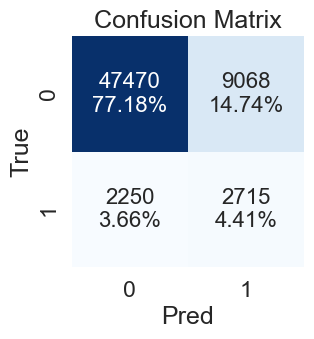

In [33]:
conf_matrix(y_test, np.where(pred>=0.60, 1, 0))

In [44]:
# gc.enable()
# del train, test
# gc.collect()

2273

In [63]:
a=np.array([1,1,4,4])
np.std(a)

1.5

## Get Samples

In [12]:
def create_sample(client_id, path_dict, save_dict):
    app=pd.read_csv(path_dict['application_test'])
    client_app=app.loc[app['SK_ID_CURR']==client_id, :].astype(app.dtypes)
    client_app.to_csv(save_dict['application_test'], index=False)
    print(f'app: {client_app.shape}')
    gc.enable(); del app, client_app; gc.collect()

    bur=pd.read_csv(path_dict['bur'])
    client_bur=bur.loc[bur['SK_ID_CURR']==client_id, :].astype(bur.dtypes)
    client_bur.to_csv(save_dict['bur'], index=False)
    print(f'bur: {client_bur.shape}')
    del bur; gc.collect()

    bb=pd.read_csv(path_dict['bb'])
    client_bb=bb.loc[bb['SK_ID_BUREAU'].isin(client_bur['SK_ID_BUREAU']), :].astype(bb.dtypes)
    client_bb.to_csv(save_dict['bb'], index=False)
    print(f'bb: {client_bb.shape}')
    del bb, client_bb, client_bur; gc.collect()

    prev=pd.read_csv(path_dict['previous'])
    client_prev=prev.loc[prev['SK_ID_CURR']==client_id, :].astype(prev.dtypes)
    client_prev.to_csv(save_dict['previous'], index=False)
    print(f'prev: {client_prev.shape}')
    del prev, client_prev; gc.collect()
    
    inst=pd.read_csv(config.PATH_DICT['installments'])
    client_inst=inst.loc[inst['SK_ID_CURR']==client_id, :].astype(inst.dtypes)
    client_inst.to_csv(save_dict['installments'], index=False)
    print(f'inst: {client_inst.shape}')
    del inst, client_inst; gc.collect()

    cash=pd.read_csv(config.PATH_DICT['cash'])
    client_cash=cash.loc[cash['SK_ID_CURR']==client_id, :].astype(cash.dtypes)
    client_cash.to_csv(save_dict['cash'], index=False)
    print(f'cash: {client_cash.shape}')
    del cash, client_cash; gc.collect()

    card=pd.read_csv(config.PATH_DICT['card_balance'])
    client_card=card.loc[card['SK_ID_CURR']==client_id, :].astype(card.dtypes)
    client_card.to_csv(save_dict['card_balance'], index=False)
    print(f'card: {client_card.shape}')
    del card, client_card; gc.collect()

create_sample(100005, config.PATH_DICT, config.SAMPLES_DICT)

app: (1, 121)
bur: (3, 17)
bb: (21, 3)
prev: (2, 37)
inst: (9, 8)
cash: (11, 8)
card: (0, 23)


In [18]:
pd.read_csv('../data/samples/cash_sample.csv').columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [2]:
def save_dtypes(df_names, path_dict, sample_dtypes_path):
    sample_dtypes_dict={}
    for i in df_names:
        print(i)
        df=pd.read_csv(path_dict[i])
        sample_dtypes_dict[i]=df.dtypes
    with open(sample_dtypes_path, 'wb') as f:
        pickle.dump(sample_dtypes_dict, f)
    return f'All datatypes saved to {sample_dtypes_path}'
  
names=['application_train','bur','bb','previous','cash','installments','card_balance']
save_dtypes(names, config.PATH_DICT, '../models/pipeline/sample_dtypes_dict.pkl')

application_train
bur
bb
previous
cash
installments
card_balance


'All datatypes saved to ../models/pipeline/sample_dtypes_dict.pkl'

In [2]:
def full_sample(client_id, samples_dict, path_dict, sample_dtypes_path):
    with open(path_dict['ohe_dict'], 'rb') as f:
        ohe_dict=pickle.load(f)
        
    with open(sample_dtypes_path, 'rb') as f:
        orig_dtypes_dict=pickle.load(f)
        
    app=application_data(samples_dict['application_test']).astype(orig_dtypes_dict['application_train'].drop('TARGET'))
    client_id=app['SK_ID_CURR'].values[0]
    try:
        bur, bb, _, _=bureau_and_bb(samples_dict['bur'], 
                                    samples_dict['bb'], 
                                    bur_ohe=ohe_dict['Bureau_OHE'], 
                                    bb_ohe=ohe_dict['BB_OHE'],
                                    remove_dup=False, sample=[orig_dtypes_dict['bur'], orig_dtypes_dict['bb']])
        bur.rename(columns=lambda s: s.replace(" ", ""), inplace=True)
        bb.rename(columns=lambda s: s.replace(" ", ""), inplace=True)
        app=app.merge(bur, on='SK_ID_CURR', how='left')
        del bur; gc.collect()
        app=app.merge(bb, on='SK_ID_CURR', how='left')
        del bb; gc.collect()
    except ValueError as e:
        print(f'{e}')
       
    
    try:
        prev, _=previous(samples_dict['previous'], prev_ohe=ohe_dict['Prev_OHE'], remove_dup=False, sample=orig_dtypes_dict['previous'])
    except ValueError as e:
        with open(path_dict['prev_temp'], 'rb') as f:
            prev=pickle.load(f)
        prev['SK_ID_CURR']=client_id
    for i in [' ', '-', ':', ')', '(', '+', '/', ',']:
        prev.rename(columns=lambda s: s.replace(i, ""), inplace=True)
    app=app.merge(prev, on='SK_ID_CURR', how='left')
    del prev; gc.collect()
      
    
    try:
        cash, _=pos_cash(samples_dict['cash'], cash_ohe=ohe_dict['Cash_OHE'], remove_dup=False, sample=orig_dtypes_dict['cash'])
    except ValueError as e:
        with open(path_dict['cash_temp'], 'rb') as f:
            cash=pickle.load(f)
        cash['SK_ID_CURR']=client_id
    cash.rename(columns=lambda s: s.replace(" ", ""), inplace=True)
    app=app.merge(cash, on='SK_ID_CURR', how='left')
    del cash; gc.collect()
      
    
    try:
        inst=installments(samples_dict['installments'], remove_dup=False, sample=orig_dtypes_dict['installments'])
    except ValueError as e:
        with open(path_dict['inst_temp'], 'rb') as f:
            inst=pickle.load(f)
        inst['SK_ID_CURR']=client_id
    inst.rename(columns=lambda s: s.replace(" ", ""), inplace=True)
    app=app.merge(inst, on='SK_ID_CURR', how='left')
    del inst; gc.collect()
    
    
    try:    
        card_b, _=card_balance(samples_dict['card_balance'], card_ohe=ohe_dict['Card_OHE'], 
                              remove_dup=False, sample=orig_dtypes_dict['card_balance'])
    except ValueError as e:
        with open(path_dict['card_temp'], 'rb') as f:
            card_b=pickle.load(f)
        card_b['SK_ID_CURR']=client_id
        
    card_b.rename(columns=lambda s: s.replace(" ", ""), inplace=True)
    app=app.merge(card_b, on='SK_ID_CURR', how='left')
    del card_b; gc.collect()
    
    with open(path_dict['dtypes'], 'rb') as f:
        final_dtypes=pickle.load(f)
        
    return app[final_dtypes.drop('TARGET').index]


In [10]:
aaa=dict(zip(config.SAMPLES_DICT.keys(), [f'../data/clients/{100001}/'+dir_ for dir_ in config.CLIENT_FILENAMES]))
aaa

{'application_test': '../data/clients/100001/application.csv',
 'bur': '../data/clients/100001/bureau.csv',
 'bb': '../data/clients/100001/bureau_balance.csv',
 'previous': '../data/clients/100001/previous_app.csv',
 'cash': '../data/clients/100001/cash.csv',
 'installments': '../data/clients/100001/installments.csv',
 'card_balance': '../data/clients/100001/card.csv'}

In [11]:
import warnings
warnings.filterwarnings('ignore')

a=full_sample(100001, aaa, config.PATH_DICT, '../models/pipeline/sample_dtypes_dict.pkl')
a.shape

Application data shape: (1, 121)
After adding features: (1, 165)
Bureau shape: (7, 17)
Bureau balance shape: (172, 3)
Dataset:bureau_balance
	Before: 2 numeric cols
	After: 5
Dataset:bureau_balance
	Before: 1 categorical cols
	After: 16
Dataset:loan
	Before: 22 numeric cols
	After: 105
Dataset:bureau
	Before: 3 categorical cols
	After: 46
Dataset:bureau
	Before: 13 numeric cols
	After: 60
Previous shape: (1, 37)
Dataset:previous
	Before: 16 categorical cols
	After: 290
Dataset:previous
	Before: 20 numeric cols
	After: 95


KeyError: "Only a column name can be used for the key in a dtype mappings argument. 'MONTHS_BALANCE' not found in columns."

In [34]:
make_prediction(a, config.PATH_DICT['model_file'], config.PATH_DICT['lgb_ohe'])

array([0.57142201])

In [20]:
with open('../models/pipeline/sample_dtypes_dict.pkl', 'rb') as f:
    orig_dtypes=pickle.load(f)

In [7]:
dict(zip(config.SAMPLES_DICT.keys(), [f'../data/clients/{100001}/'+dir_ for dir_ in config.CLIENT_FILENAMES]))

{'application_test': '../data/clients/100001/application.csv',
 'bur': '../data/clients/100001/bureau.csv',
 'bb': '../data/clients/100001/bureau_balance.csv',
 'previous': '../data/clients/100001/previous_app.csv',
 'cash': '../data/clients/100001/cash.csv',
 'installments': '../data/clients/100001/installments.csv',
 'card_balance': '../data/clients/100001/card.csv'}

In [24]:
pd.read_csv('../data/clients/100001/cash.csv').astype(orig_dtypes['cash'])

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1851984,100001,-96,4.0000,2.0000,Active,0,0
1,1851984,100001,-95,4.0000,1.0000,Active,7,7
2,1369693,100001,-53,4.0000,0.0000,Completed,0,0
3,1369693,100001,-54,4.0000,1.0000,Active,0,0
4,1851984,100001,-93,4.0000,0.0000,Completed,0,0
5,1369693,100001,-57,4.0000,4.0000,Active,0,0
6,1369693,100001,-55,4.0000,2.0000,Active,0,0
7,1851984,100001,-94,4.0000,0.0000,Active,0,0
8,1369693,100001,-56,4.0000,3.0000,Active,0,0
